Here are represented local search algorithms: classic local search for descrete domain with gradient being Monte Carlo (random), Simulated Annealing and RVNS (Random Variable Neighborhood Search).

In [1]:
graphName = "graphs/testGraph.txt"
costsName = "graphs/testGraphCosts.txt"

In [2]:
from collections import defaultdict

# Nodes in DAG that are represented as (node, [list of ancestor])
def getImmediateAncestors(filename):
    with open(filename, 'r') as file:
        nodes = defaultdict(list)
        
        # Dummy nodes source and super sink that are added to represent start and end of project
        sourceNodes = set()
        superSinkNodes = set()
        removeFromeSource = set()
        removeFromSuperSink = set()
        
        # Necessary representation for networkx to draw graph
        GxNodes = set()
        GxEdges = []
            
        for line in file:
            # from represented direceted edges as (node ancestor) we get all ancestors
            node, ancestor = line.split()
            
            GxEdges.append((node, ancestor))
            
            nodes[node].append(ancestor)
            sourceNodes.add(node)
            superSinkNodes.add(ancestor)
            removeFromeSource.add(ancestor)
            removeFromSuperSink.add(node)
        
        for node in removeFromeSource:
            sourceNodes.discard(node)
        for node in removeFromSuperSink:
            superSinkNodes.discard(node)
            
        nodes['s'] = list(sourceNodes)
        nodes['ss'] = [None]
        for node in superSinkNodes:
            nodes[node].append('ss')
            GxEdges.append((node, 'ss'))
        
        for s in sourceNodes:
            GxEdges.append(('s', s))
        GxNodes = list(sourceNodes)
        
#         for node in nodes:
#             print(node, nodes[node])

        # return values are directed acyclic graph represened as dictionary with nodes and their ancestors
        # and GxNodes, GxEdges which is needed representation of graph for drawing
        return nodes, GxNodes, GxEdges

In [3]:
nodes, GxNodes, GxEdges = getImmediateAncestors(graphName)

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def drawGraph(GxNodes, GxEdges):
    # init empty graph
    Gx = nx.Graph()
    # add starting node
    Gx.add_nodes_from('s')
    # add list of remaining nodes
    Gx.add_nodes_from(GxNodes)
    # add edges
    Gx.add_edges_from(GxEdges)
    nx.draw_networkx(Gx,node_size=900, arrows=True, arrowstyle='-|>')

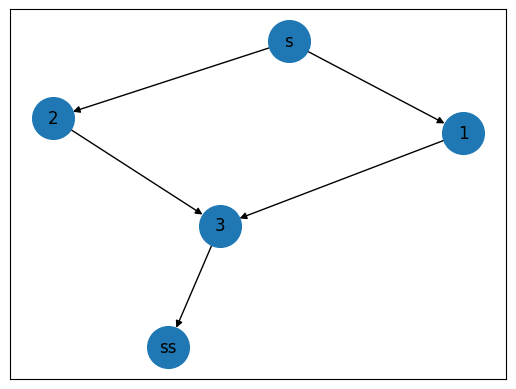

In [5]:
drawGraph(GxNodes, GxEdges)

In [6]:
def getCost(filename):
    
    with open(filename, 'r') as file:
        nodes = defaultdict(list)
        currentNode = -1
        
        for line in file:
            values = line.split()
            if values[0] == 'n':
                currentNode = values[1]
                nodes[currentNode] = []
            for index in range(2, len(values)):
                duration, cost = values[index].split(',')
                duration = int(duration[1:])
                cost = int(cost[:-1])
                nodes[currentNode].append((duration, cost))

        return nodes

In [7]:
costs = getCost(costsName)

In [8]:
def generateSolution(costs):
    solution = [0 for _ in range(len(costs))]
    
    for node in costs:
        if node == 's' or node == 'ss':
            continue
        solution[int(node)] = random.randrange(len(costs[node]))
    
    return solution

In [9]:
def budgetValue(costs, solution, budget):
    cost = 0
    for index in range(1, len(solution)-1):
        cost += costs[str(index)][solution[index]][1]
    return cost

In [10]:
def isFeasible(costs, solution, budget):
    return budgetValue(costs, solution, budget) < budget

In [11]:
def generateFeasibleSolution(costs, budget):
    solution = [0 for _ in range(len(costs))]
    
    for node in costs:
        if node == 's' or node == 'ss':
            continue
        solution[int(node)] = random.randrange(len(costs[node]))
    
    if not isFeasible(costs, solution, budget):
        return generateFeasibleSolution(costs, budget)
    else: 
        return solution

In [12]:
def getEarliestStartTime(nodes, solution, graph, earliestStartTime):
    if nodes == []:
        return earliestStartTime
    durations = set()
    newNodes = set()
#     print(nodes)
    for node in nodes:
#         print(node)
        if node == 'ss':
            durations.add(0)
            continue
        step = solution[int(node)]
        durations.add(costs[node][step][0])
        for ancestor in graph[node]:
            newNodes.add(ancestor)
    earliestStartTime += max(durations)
    return getEarliestStartTime(list(newNodes), solution, graph, earliestStartTime)

In [13]:
def solutionValue(solution, costs, graph):
    return getEarliestStartTime(graph['s'], solution, graph, 0)

In [14]:
def changeSolution(solution, costs, graph):
#     print("changeSolution", solution)
    changeStep = random.randrange(1, len(solution) - 1)
    step = random.randrange(len(costs[str(changeStep)]))
    if step == solution[changeStep]:
        return changeSolution(solution, costs, graph)
    else:
        oldValue = solution[changeStep]
        solution[changeStep] = step
#         print("changeSolution", solution)
        return (changeStep, oldValue)

In [15]:
import random 

def localSearch(costs, nodes, iters, budget):
    solution = generateFeasibleSolution(costs, budget)
    currValue = solutionValue(solution, costs, nodes)
    bestValue = currValue
    
    for i in range(iters):
        step, oldValue = changeSolution(solution, costs, nodes)
        if not isFeasible(costs, solution, budget):
            solution[step] = oldValue
        else:
            newValue = solutionValue(solution, costs, nodes)
            if newValue < currValue:
                currValue = newValue
                if newValue < bestValue:
                    bestValue = newValue
            else:
                solution[step] = oldValue
    return bestValue, solution, budgetValue(costs, solution, budget)

In [16]:
duration, solution, projectCost = localSearch(costs, nodes, 100, 30)
print(duration, solution, projectCost)

7 [0, 1, 0, 1, 0] 26


In [17]:
def simulatedAnnealing(costs, nodes, iters, budget):
    solution = generateFeasibleSolution(costs, budget)
    currValue = solutionValue(solution, costs, nodes)
    bestValue = currValue
    
    for i in range(1, iters + 1):
        step, oldValue = changeSolution(solution, costs, nodes)
        if not isFeasible(costs, solution, budget):
            solution[step] = oldValue
        else:
            newValue = solutionValue(solution, costs, nodes)
            if newValue < currValue:
                currValue = newValue
                if newValue < bestValue:
                    bestValue = newValue
            else:
                p = 1.0 / i ** 0.5
                q = random.uniform(0, 1)
                if p > q:
                    currValue = newValue
                else:
                    solution[step] = oldValue
    return bestValue, solution, budgetValue(costs, solution, budget)

In [18]:
duration, solution, projectCost  = simulatedAnnealing(costs, nodes, 100, 30)
print(duration, solution, projectCost)

7 [0, 1, 0, 1, 0] 26


In [19]:
def getNeighborSolution(solution, k):
    indices = range(1, len(solution) - 1)
    changeSteps = random.sample(indices, k)
    
    oldValues = []
    
    for index in changeSteps:
        changeStep = random.randrange(1, len(solution) - 1)
        step = random.randrange(len(costs[str(index)]))
        
        oldValues.append(solution[index])
        solution[index] = step
        
    return (changeSteps, oldValues)
        

In [20]:
def restoreOldValue(solution, changeSteps, oldValues):
    for i in range(len(changeSteps)):
        solution[changeSteps[i]] = oldValues[i]
    

In [21]:
MAX_K = 3

In [22]:
def RVNS(costs, nodes, iters, budget, max_k):
    solution = generateFeasibleSolution(costs, budget)
    currValue = solutionValue(solution, costs, nodes)
    bestValue = currValue
    
    for i in range(1, iters + 1):
        k = 0
        while k <= max_k:
            changeSteps, oldValues = getNeighborSolution(solution, k)
            if not isFeasible(costs, solution, budget):
                restoreOldValue(solution, changeSteps, oldValues)
                continue
            newValue = solutionValue(solution, costs, nodes)
            if newValue < currValue:
                currValue = newValue
                if newValue < bestValue:
                    bestValue = newValue
                break
            else:
                k += 1
                restoreOldValue(solution, changeSteps, oldValues)
    return bestValue, solution, budgetValue(costs, solution, budget)     

In [23]:
duration, solution, projectCost = RVNS(costs, nodes, 100, 30, MAX_K)
print(duration, solution, projectCost)

7 [0, 1, 0, 1, 0] 26


In [24]:
import time

def executeAlgorithms(graph, costs, budget, iters):
    
    print("--------------------------------------- " + str(iters) + " ---------------------------------------")
    
    start = time.perf_counter()
    duration, solution, projectCost = localSearch(costs, nodes, iters, budget)
    print("Solution: ", solution)
    print("Duration: ", duration)
    print("Cost: ", projectCost)        
    end = time.perf_counter()
    executionTime = end - start
    print("Time needed for Local Search execution: " + str(executionTime))
    
    print()
    
    start = time.perf_counter()
    duration, solution, projectCost = simulatedAnnealing(costs, nodes, iters, budget)
    print("Solution: ", solution)
    print("Duration: ", duration)
    print("Cost: ", projectCost)        
    end = time.perf_counter()
    executionTime = end - start
    print("Time needed for Simulated Annealing execution: " + str(executionTime))
    
    print()
    
    start = time.perf_counter()
    duration, solution, projectCost = RVNS(costs, nodes, iters, budget, MAX_K)
    print("Solution: ", solution)
    print("Duration: ", duration)
    print("Cost: ", projectCost)        
    end = time.perf_counter()
    executionTime = end - start
    print("Time needed for RVNS execution: " + str(executionTime))
    
    print()

In [25]:
executeAlgorithms(nodes, costs, 26, 100)

--------------------------------------- 100 ---------------------------------------
Solution:  [0, 1, 0, 2, 0]
Duration:  9
Cost:  21
Time needed for Local Search execution: 0.002632908999657957

Solution:  [0, 1, 0, 2, 0]
Duration:  9
Cost:  21
Time needed for Simulated Annealing execution: 0.0018179590006184299

Solution:  [0, 1, 0, 2, 0]
Duration:  9
Cost:  21
Time needed for RVNS execution: 0.035068593999312725



In [ ]:
graphName = "graphs/graph5.txt"
costsName = "graphs/graph5costs.txt"
nodes, GxNodes, GxEdges = getImmediateAncestors(graphName)
costs = getCost(costsName)
budget = 3000

for iters in [100, 1000, 10000, 100000]:
    executeAlgorithms(nodes, costs, budget, iters)

drawGraph(GxNodes, GxEdges)


--------------------------------------- 100 ---------------------------------------
Solution:  [0, 0, 1, 0, 1, 0, 1, 1, 3, 2, 1, 0, 0, 1, 1, 1, 3, 1, 3, 1, 0, 0, 2, 3, 0, 3, 1, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Duration:  36
Cost:  1825
Time needed for Local Search execution: 0.03693024499807507

Solution:  [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 1, 0, 1, 2, 1, 0, 1, 1, 0, 1, 2, 1, 2, 0, 2, 2, 0, 0, 1, 0, 1, 1, 2, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0]
Duration:  46
Cost:  2145
Time needed for Simulated Annealing execution: 0.019257961001130752

Solution:  [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 2, 2, 0, 1, 2, 2, 0, 1, 0, 0, 1, 1, 2, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 2, 0, 0, 0, 0, 1, 0, 1, 0, 2, 2, 0]
Duration:  43
Cost:  2186
Time needed for RVNS execution: 0.06200325600002543

--------------------------------------- 1000 ---------------------------------------
Solution:  [0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 1, 0, 